<a href="https://colab.research.google.com/github/Jerryson520/Optiver-Trading-at-Close/blob/main/Experiment_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing
# !pip install -q  lightgbm==4.1.0 \
#   --config-settings=cmake.define.USE_GPU=ON \
#   --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
#   --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

In [ ]:
# # !pip install lightgbm
!pip install scikit-learn==1.5.2

In [ ]:
# !pip install numpy==1.26.4

In [ ]:
work_dir = '/content/drive/MyDrive/Optiver-trading-at-close'

# Standard Libraries
import os
import collections
import random
import sys

# Data Science Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Configure Visualization
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from utils import inspect_columns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn
import lightgbm
import xgboost as xgb
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# import cupy as cp
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)


# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# utils.py
def inspect_columns(df):
    """
    Inspect various characteristics of columns in a DataFrame, providing
    details on column lengths, uniqueness, cardinality, null values, sample rows,
    and data types.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame to inspect.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame where each row represents a column from the input DataFrame,
        with the following columns:
        - 'len': The total number of rows in the DataFrame.
        - 'unique': A boolean indicating if all values in the column are unique.
        - 'cardinality': The number of unique values in each column.
        - 'null_cnt': The count of null (NaN) values in each column.
        - 'null_pct': The percentage of null (NaN) values in each column.
        - '1st_row': The value in the first row of each column.
        - 'random_row': A random value from each column.
        - 'last_row': The value in the last row of each column.
        - 'dtype': The data type of each column.

    Example:
    -------
    >>> df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, None]})
    >>> inspect_columns(df)
           len  unique  cardinality  null_cnt    null_pct 1st_row  random_row  last_row dtype
    A       3    False          3       0          0.0      1         2          3       int64
    B       3    False          2       1         33.33     4         5        None       float64
    """
    result = pd.DataFrame(
        {
            "len": len(df),
            "unique": df.nunique() == len(df),
            "cardinality": df.nunique(),
            "null_cnt": df.isna().sum(),
            "null_pct": df.isnull().sum() / len(df) * 100,
            "1st_row": df.iloc[0],
            "random_row": df.iloc[np.random.randint(low=0, high=len(df))],
            "last_row": df.iloc[-1],
            "dtype": df.dtypes,
        }
    )

    return result

### Config

In [ ]:
GENERATE_FEATURE = True
USE_PCA = False
XGBOOST = True
XGBOOST_FEVAL = True
XGBOOST_FSELECTION = False

## Load Data

In [ ]:
input_path = work_dir + '/train.csv'
df = pd.read_csv(input_path)
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


## Missing value imputation

In [ ]:
# step 1,2
df_cleaned = (
    df.dropna(subset='target')
    .dropna(subset='wap')
)

# step 3
df_cleaned.loc[(df_cleaned['seconds_in_bucket'] <= 300) & (df_cleaned['far_price'].isnull()), 'far_price'] = 0
df_cleaned.loc[(df_cleaned['seconds_in_bucket'] <= 300) & (df_cleaned['near_price'].isnull()), 'near_price'] = 0

# step 4:
# df_cleaned = df_cleaned.dropna().reset_index(drop=True)
df_cleaned = df_cleaned.fillna(0).reset_index(drop=True)

inspect_columns(df_cleaned)

,len,unique,cardinality,null_cnt,null_pct,1st_row,random_row,last_row,dtype
stock_id,5237760,False,200,0,0.0,0,105,199,int64
date_id,5237760,False,481,0,0.0,0,157,480,int64
seconds_in_bucket,5237760,False,55,0,0.0,0,400,540,int64
imbalance_size,5237760,False,2971863,0,0.0,3180602.69,8171014.01,1884285.71,float64
imbalance_buy_sell_flag,5237760,False,3,0,0.0,1,-1,-1,int64
reference_price,5237760,False,28741,0,0.0,0.999812,0.999085,1.002129,float64
matched_size,5237760,False,2948862,0,0.0,13380276.64,45400515.87,24073677.32,float64
far_price,5237760,False,95740,0,0.0,0.0,0.986066,1.000859,float64
near_price,5237760,False,84626,0,0.0,0.0,0.988959,1.001494,float64
bid_price,5237760,False,28313,0,0.0,0.999812,0.999085,1.002129,float64


In [ ]:
(df_cleaned.groupby(['date_id', 'stock_id'])['seconds_in_bucket'].size() != 55).sum()

0

In [ ]:
df_sampling = df_cleaned.query('date_id <= 480 and date_id >= 450').reset_index(drop=True)

In [ ]:
len(df_sampling)

341000

In [ ]:
(df_sampling.groupby(['date_id', 'stock_id'])['seconds_in_bucket'].size() != 55).sum()

0

## Feature Engineering

In [ ]:
# (
#     df_sampling.set_index('seconds_in_bucket').groupby(['stock_id', 'date_id'])
#     [['target']].apply(lambda x: x[['target']].shift(1, fill_value=0))
# ).plot()

In [ ]:
df_sampling

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,450,0,6142558.25,1,0.999912,13264336.31,0.000000,0.000000,0.999912,7956.06,1.000079,7179.60,1.000000,-1.109838,24750,450_0_0
1,1,450,0,1310860.38,1,1.000074,1589558.48,0.000000,0.000000,0.999976,6732.66,1.000074,20404.00,1.000000,18.559694,24750,450_0_1
2,2,450,0,5410435.23,1,1.000712,4697298.14,0.000000,0.000000,0.999170,26308.73,1.001458,46296.70,1.000000,4.609823,24750,450_0_2
3,3,450,0,11951807.40,1,0.999705,58138966.48,0.000000,0.000000,0.999351,80545.30,1.000008,990.15,1.000000,-0.630021,24750,450_0_3
4,4,450,0,7575764.95,1,0.999792,17294499.89,0.000000,0.000000,0.999792,1992.54,1.000454,4350.24,1.000000,-4.580021,24750,450_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
340996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
340997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
340998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


After exploration, we find that nan appears in the data is because:
1. reference_price = bid_price = wap
2. imbalance_buy_sell_flag cannot calculate return
3. fill with bfill
4. replace inf or -inf with 0.

In [ ]:
from numba import njit, prange
from tqdm.notebook import tqdm
from time import sleep

# @njit(parallel=True)
def imbalance_features(df):
    new_df = pd.DataFrame()

    # normalized imbalance
    ## sizes
    sizes = ['imbalance_buy_sell_flag','imbalance_size', 'matched_size', 'bid_size', 'ask_size']
    for i, a in tqdm(enumerate(sizes), total=len(sizes), desc='Normalized imbalance: sizes', leave=True):
        for j, b in enumerate(sizes):
            if i > j:
                new_df[f'{a}_{b}_imb'] = df.apply(lambda row: (row[a] - row[b]) / (row[a] + row[b]) if row[a] + row[b] != 0 else 0, axis=1)
            sleep(0.1)


    ## prices
    prices = ['reference_price', 'ask_price', 'bid_price', 'wap']
    for i, a in tqdm(enumerate(prices),  total=len(prices), desc='Normalized imbalance: prices', leave=True):
        for j, b in enumerate(prices):
            if i > j:
                new_df[f'{a}_{b}_imb'] = df.apply(lambda row: (row[a] - row[b]) / (row[a] + row[b]) if row[a] + row[b] != 0 else 0, axis=1)
            sleep(0.1)

    # Triplet imbalance
    for i, a in tqdm(enumerate(prices),  total=len(prices), desc='Price triplet imbalance', leave=True):
        for j, b in enumerate(prices):
            for k, c in enumerate(prices):
                if i > j and j > k:
                    max_ = df[[a,b,c]].max(axis=1)
                    min_ = df[[a,b,c]].min(axis=1)
                    mid_ = df[[a,b,c]].sum(axis=1)-min_-max_

                    new_df[f'{a}_{b}_{c}_imb2'] = np.where((mid_ == min_), 0, (max_-mid_)/(mid_-min_))
                sleep(0.1)


    # Cross Features
    for i, a in tqdm(enumerate(sizes+prices), total=len(sizes+prices), desc='All Cross imbalance', leave=True):
        for j, b in enumerate(sizes+prices):
            if i > j:
                new_df[f'{a}_{b}_cross_imb'] = df.eval(f'{a} * {b}')
            sleep(0.1)


    return pd.concat([df, new_df], axis=1) # df.fillna(0).replace([-float('inf'), float('inf')], 0)

In [ ]:
def statistical_features(df):
    new_df = pd.DataFrame()

    new_df['volume'] = df.eval('ask_size + bid_price')
    new_df['reference_volume'] = df.eval('imbalance_size + matched_size')
    new_df['mid_size'] = df.eval('(ask_size + bid_size)/2')
    new_df['mid_price'] = df.eval('(ask_price + bid_price)/2')
    new_df['spread'] = df.eval('ask_price - bid_price')


    # Calculate various statistical aggregation features
    prices = ['reference_price', 'ask_price', 'bid_price', 'wap']
    for func in ["mean", "std", "skew", "kurt"]: # highly correlated features
        df.loc[:, f"all_prices_{func}"] = df[prices].agg(func, axis=1)

    return pd.concat([df, new_df], axis=1) # .fillna(0).replace([-float('inf'), float('inf')], 0)

In [ ]:
def temporal_features(df):
    new_df = pd.DataFrame()

    # Lag Features
    # for col in tqdm(['bid_size', 'ask_size', 'matched_size', 'imbalance_size', 'reference_price'], desc='process 1'):
    feat = ['bid_size', 'ask_size', 'matched_size', 'imbalance_size', 'reference_price']
    for window in tqdm(range(1, 11), desc='Lag features'):
        new_feat =[f"{col}_diff_{window}" for col in feat]
        new_df[new_feat] = df.groupby(['stock_id', 'date_id'])[[
            'bid_size', 'ask_size', 'matched_size', 'imbalance_size', 'reference_price'
        ]].transform(lambda x: x.shift(window).bfill())
            # df.loc[:, f"{col}_ret_{window}"] = df.groupby(['stock_id', 'date_id'])[col].transform(lambda x: x.pct_change(window, fill_method=None).bfill())


    # Difference Features
    feat = ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'matched_size', 'imbalance_size', 'spread']
    # for col in tqdm(['ask_price', 'bid_price', 'ask_size', 'bid_size', 'matched_size', 'imbalance_size', 'spread'], desc='process 2'):
    for window in tqdm(range(1, 11), desc='Difference features'):
        new_feat = [f"{col}_diff_{window}" for col in feat]
        new_df[new_feat] = df.groupby(['stock_id', 'date_id'])[[
            'ask_price', 'bid_price', 'ask_size', 'bid_size', 'matched_size', 'imbalance_size', 'spread'
        ]].transform(lambda x: x.diff(window).fillna(0))


    # level2 feature
    for window in tqdm(range(1, 11), desc='Level2 features'):
        # df.loc[:, f'price_change_diff_{window}'] = df.loc[:, f'bid_price_diff_{window}'] - df.loc[:, f'ask_price_diff_{window}']
        # df.loc[:, f'size_change_diff_{window}'] = df.loc[:, f'bid_size_diff_{window}'] - df.loc[:, f'ask_size_diff_{window}']
        new_df[f'price_change_diff_{window}'] = new_df.eval(f'bid_price_diff_{window} - ask_price_diff_{window}')
        new_df[f'size_change_diff_{window}'] = new_df.eval(f'bid_size_diff_{window} - ask_size_diff_{window}')


    return pd.concat([df, new_df], axis=1) # .fillna(0).replace([-float('inf'), float('inf')], 0)

In [ ]:
GENERATE_FEATURE = False
if GENERATE_FEATURE:
  df_sampling_w_feat = imbalance_features(df_sampling)
  print(len(df_sampling_w_feat))
  df_sampling_w_feat = statistical_features(df_sampling_w_feat)
  print(len(df_sampling_w_feat))
  df_sampling_w_feat = temporal_features(df_sampling_w_feat)
  print(len(df_sampling_w_feat))
else:
  df_sampling_w_feat = pd.read_parquet('/content/drive/MyDrive/Optiver-trading-at-close/df_sampling_w_feat.parquet')

In [ ]:
# df_sampling_w_feat.to_parquet('/content/drive/MyDrive/Optiver-trading-at-close/df_sampling_w_feat.parquet')
len(df_sampling_w_feat)

341000

In [ ]:
# df_sampling_w_feat.to_parquet('/content/drive/MyDrive/Optiver-trading-at-close/df_sampling_w_feat.parquet')

In [ ]:
# (
#     df_sampling.query('stock_id == 0 and (date_id == 450)')
#     .set_index('seconds_in_bucket')['target'].plot()
# )

# df_111 = df_sampling.query('stock_id == 0 and (date_id == 451)').set_index('seconds_in_bucket')
# df_111.index += 540
# (
#     df_111['target'].plot()
# )

This means we should take each date inidividually rather than combining all dates

## Feature selection

In [ ]:
def PCA_result(pca, threshold=0.99):
  # Assuming PCA is already fitted
  ratio = pca.explained_variance_ratio_  # Explained variance ratio

  # Set up the plot
  fig, ax = plt.subplots(figsize=(8, 6))

  # Calculate the cumulative sum of the explained variance ratio
  cumsum_ratio = ratio.cumsum()

  # Find the index where cumulative variance reaches or exceeds 99%
  x_flex = np.where(cumsum_ratio >= threshold)[0][0]  # Index of the first point >= 99%
  flexpoint = cumsum_ratio[x_flex]              # Corresponding cumulative value

  # Plot the cumulative explained variance ratio
  sns.lineplot(x=range(1, len(cumsum_ratio) + 1), y=cumsum_ratio, ax=ax, label="Cumulative Explained Variance")

  # Highlight the 99% threshold point with a red dot
  sns.scatterplot(x=[x_flex + 1], y=[flexpoint], color='red', ax=ax, s=100)
  ax.text(x_flex + 1.5, flexpoint - 0.01, f'({x_flex + 1}, {flexpoint:.2%})', color='red')

  # Add titles, labels, and threshold line
  ax.set_title("Cumulative Explained Variance Ratio", fontsize=14)
  ax.set_xlabel("Number of Principal Components", fontsize=12)
  ax.set_ylabel("Cumulative Explained Variance", fontsize=12)
  ax.legend()
  plt.show()

In [ ]:
if USE_PCA:
  ss = StandardScaler()
  pca = PCA()
  pca.fit(ss.fit_transform(df_sampling_w_feat.drop('target', axis=1)))
  PCA_result(pca, threshold=0.99)

## Data Sampling

In [ ]:
len(df_sampling_w_feat)

341000

In [ ]:
# df_sampling = df_cleaned_new.query('date_id <= 480 and date_id >= 450')

# 3 weeks for training and 1 week for testing
df_sampling_dev = df_sampling_w_feat.query('date_id <= (450 + 21)')
df_sampling_test = df_sampling_w_feat.query('date_id > (450 + 21)')
group_label = df_sampling_dev['date_id'].apply(lambda x: (x-450)//7)
group_label

,date_id
0,0
1,0
2,0
3,0
4,0
...,...
241995,3
241996,3
241997,3
241998,3


In [ ]:
X_dev, y_dev = df_sampling_dev.drop(['target', 'row_id'], axis=1), df_sampling_dev['target']
X_test, y_test = df_sampling_test.drop(['target', 'row_id'], axis=1), df_sampling_test['target']

# Initialize your GroupTimeSeriesSplit
cv_args = {"test_size": 1, "train_size": 1}
cv = GroupTimeSeriesSplit(**cv_args).split(X_dev, y_dev, groups=group_label)

In [ ]:
len(X_dev) + len(X_test)

341000

In [ ]:
# X_test

## XGBoost

In [ ]:
# Define the pipeline
if XGBOOST:
  xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
  )

  xgb_pipeline.fit(X_dev, y_dev)
  print(mean_absolute_error(y_test, xgb_pipeline.predict(X_test)))

5.705570604556266


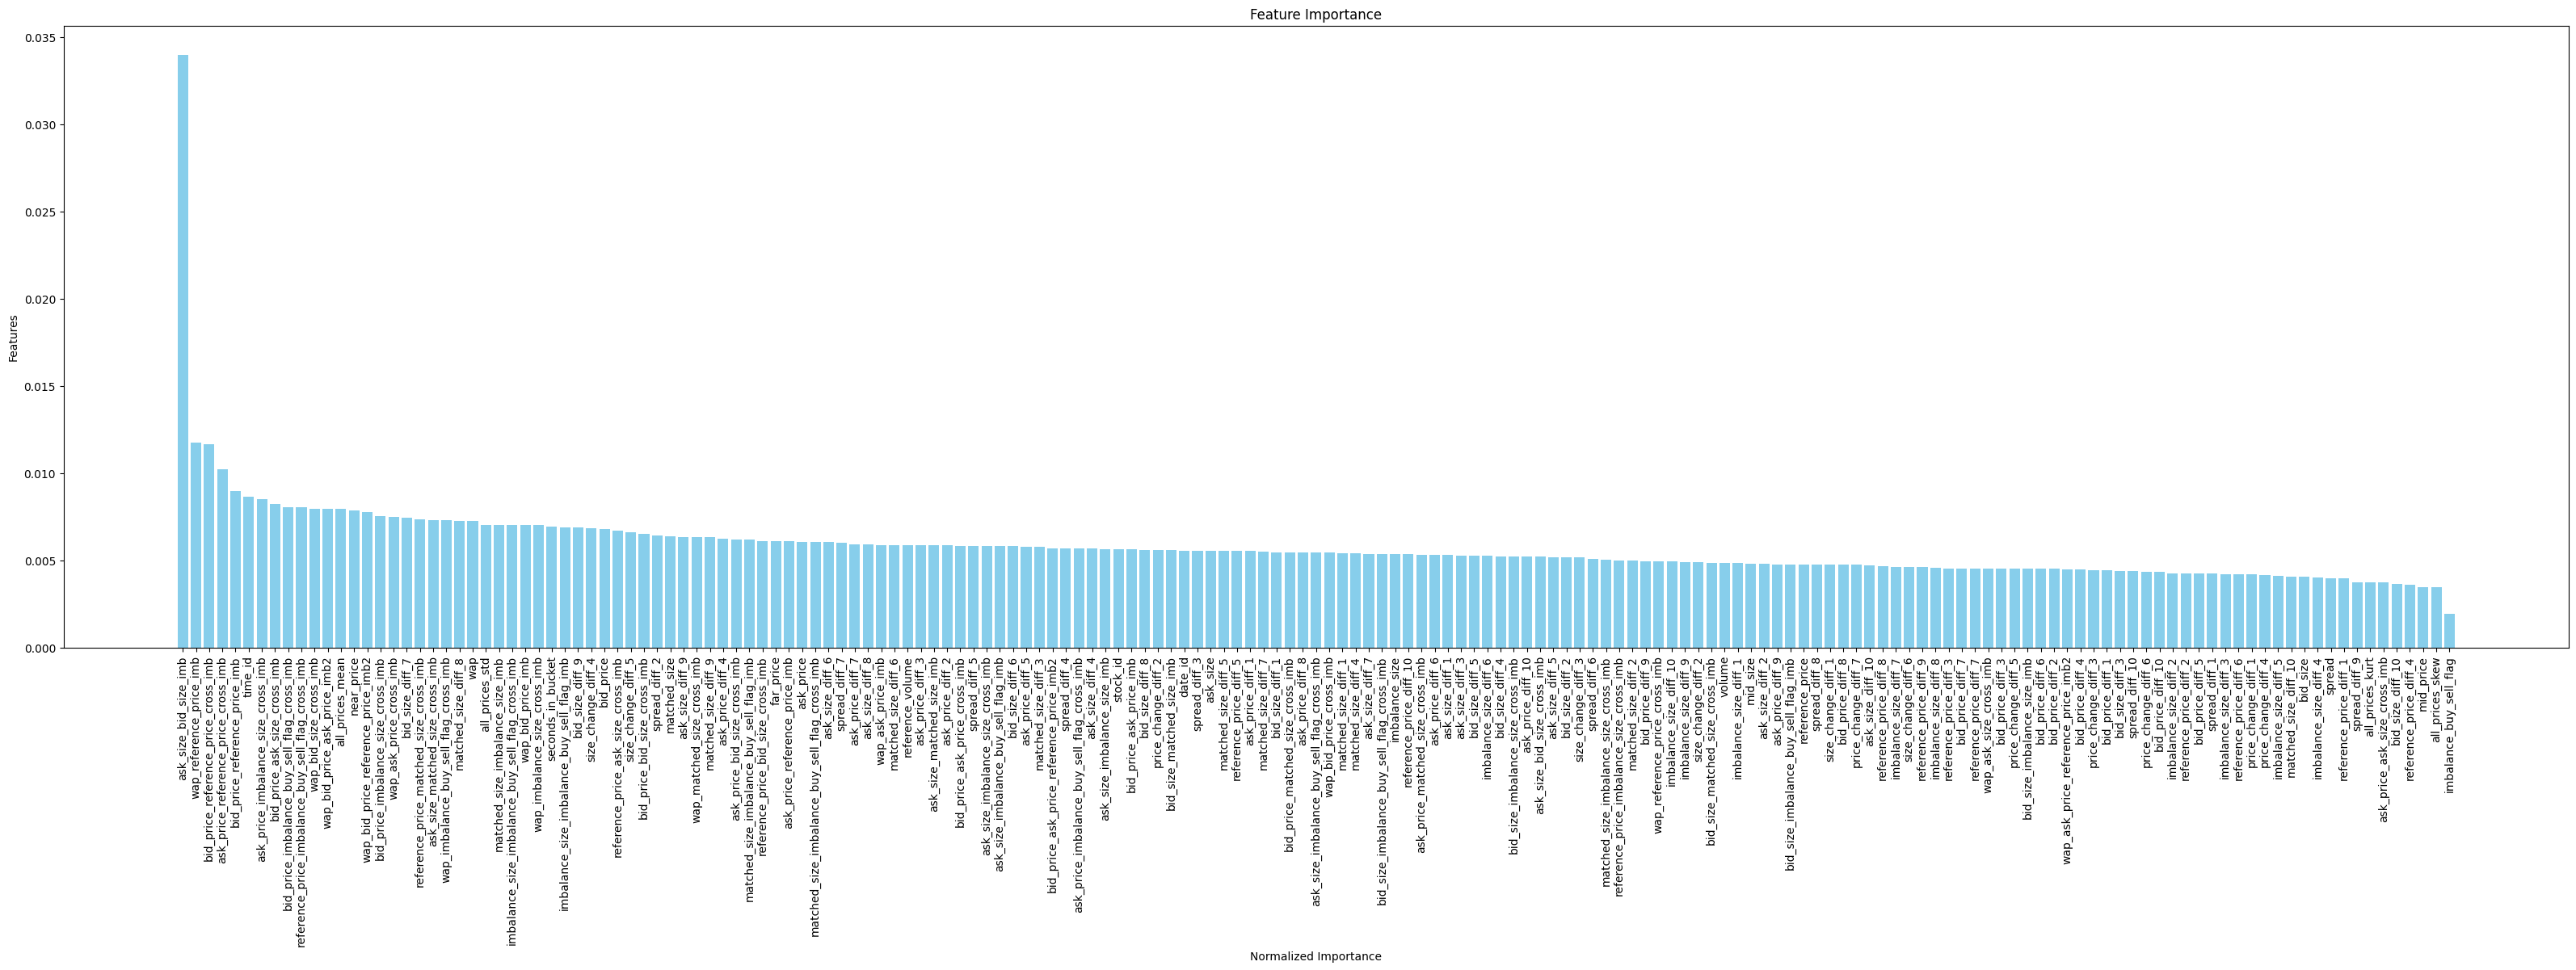

In [ ]:
if XGBOOST_FEVAL:
  fig, ax = plt.subplots(1,1,figsize=(40, 10))
  # xgb_clf = xgb_pipeline.named_steps['xgbregressor']
  # xgb_clf.get_booster().feature_names = list(X_dev.columns)
  # xgb.plot_importance(xgb_clf.get_booster(), importance_type='gain', ax=ax, values_format='{v:.2f}')
  booster = xgb_pipeline.named_steps['xgbregressor'].get_booster()
  importance_dict = booster.get_score(importance_type='gain')  # Replace 'gain' with 'weight' or 'cover'
  importance_dict = {name: item[1] for name, item in zip(X_dev.columns, importance_dict.items())}
  # Using get_score
  importance_values = list(importance_dict.values())
  normalized_importance_dict = {k: v / sum(importance_values) for k, v in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)}
  # Create horizontal bar plot
  ax.bar(list(normalized_importance_dict.keys()), list(normalized_importance_dict.values()), color='skyblue')
  ax.set_xlabel('Normalized Importance')
  plt.xticks(rotation=90)
  ax.set_ylabel('Features')
  ax.set_title('Feature Importance')

In [ ]:
lst = list(normalized_importance_dict.keys())
len(lst)

173

In [ ]:
# Define the pipeline
if XGBOOST:
  xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
  )

  xgb_pipeline.fit(X_dev[lst[:97]], y_dev)
  print(mean_absolute_error(y_test, xgb_pipeline.predict(X_test[lst[:97]])))

5.7852325242972285


In [ ]:
lst

['ask_size_bid_size_imb',
 'wap_reference_price_imb',
 'bid_price_reference_price_cross_imb',
 'ask_price_reference_price_cross_imb',
 'bid_price_reference_price_imb',
 'time_id',
 'ask_price_imbalance_size_cross_imb',
 'bid_price_ask_size_cross_imb',
 'bid_price_imbalance_buy_sell_flag_cross_imb',
 'reference_price_imbalance_buy_sell_flag_cross_imb',
 'wap_bid_size_cross_imb',
 'wap_bid_price_ask_price_imb2',
 'all_prices_mean',
 'near_price',
 'wap_bid_price_reference_price_imb2',
 'bid_price_imbalance_size_cross_imb',
 'wap_ask_price_cross_imb',
 'bid_size_diff_7',
 'reference_price_matched_size_cross_imb',
 'ask_size_matched_size_cross_imb',
 'wap_imbalance_buy_sell_flag_cross_imb',
 'matched_size_diff_8',
 'wap',
 'all_prices_std',
 'matched_size_imbalance_size_imb',
 'imbalance_size_imbalance_buy_sell_flag_cross_imb',
 'wap_bid_price_imb',
 'wap_imbalance_size_cross_imb',
 'seconds_in_bucket',
 'imbalance_size_imbalance_buy_sell_flag_imb',
 'bid_size_diff_9',
 'size_change_diff_4

In [ ]:
if XGBOOST_FSELECTION:
  res = []
  lst = list(normalized_importance_dict.keys())
  for i in tqdm(range(1, 177)):
    xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
    )
    xgb_pipeline.fit(X_dev[lst[:i]], y_dev) # i = 79 # pca.transform(X_dev)[:, :5]
    res.append(mean_absolute_error(y_test, xgb_pipeline.predict(X_test[lst[:i]])))

  res_curve = pd.DataFrame({'num_of_features': list(range(1, 177)), 'mae': res})
  sns.lineplot(x='num_of_features', y='mae', data=res_curve)

In [ ]:
# sorted({i: mae for i, mae in enumerate(res)}.items(), key=lambda x: x[1])

## LightGBM

In [ ]:
lgbm_pipeline = make_pipeline(
    MinMaxScaler(),
    LGBMRegressor(
        objective='mae',
        random_state=42,
        # device='gpu',
        callbacks=[
                lightgbm.early_stopping(stopping_rounds=100, first_metric_only=True),
                lightgbm.log_evaluation(period=100),
            ],
    )
)

In [ ]:
lgbm_pipeline.fit(
    X_dev[lst[:97]],
    y_dev,
    lgbmregressor__eval_set=[(X_test[lst[:97]], y_test)])

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd71f381f00>
[LightGBM] [Warning] Unknown parameter: 0x7bd71f383400>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd71f382c50>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7bd71f380310>
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096836 s

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor',
                 LGBMRegressor(callbacks=[<lightgbm.callback._EarlyStoppingCallback object at 0x7bd6b25348b0>,
                                          <lightgbm.callback._LogEvaluationCallback object at 0x7bd6b2535b40>],
                               objective='mae', random_state=42))])

In [ ]:
mean_absolute_error(y_test, lgbm_pipeline.predict(X_test[lst[:97]]))

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd7215bb4c0>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: 0x7bd7215bbe50>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object


5.597769179284816

## Training CatBoost

In [ ]:
!pip install catboost

In [ ]:
import catboost
from catboost import CatBoostRegressor

In [ ]:
cat_pipeline = make_pipeline(
    MinMaxScaler(),
    CatBoostRegressor(
        loss_function='MAE',
        random_state=42,
        early_stopping_rounds=100,
        verbose=100
    )
)

In [ ]:
cat_pipeline.fit(X_dev[lst[:97]], y_dev)
mean_absolute_error(y_test, cat_pipeline.predict(X_test[lst[:97]]))

0:	learn: 6.0444145	total: 48.1ms	remaining: 48.1s
100:	learn: 5.9466979	total: 4.95s	remaining: 44.1s
200:	learn: 5.9120031	total: 9.31s	remaining: 37s
300:	learn: 5.8854163	total: 13.7s	remaining: 31.8s
400:	learn: 5.8614052	total: 17.4s	remaining: 26s
500:	learn: 5.8345013	total: 20.8s	remaining: 20.7s
600:	learn: 5.8088517	total: 24.3s	remaining: 16.1s
700:	learn: 5.7855165	total: 27.7s	remaining: 11.8s
800:	learn: 5.7624161	total: 31.4s	remaining: 7.81s
900:	learn: 5.7409129	total: 34.9s	remaining: 3.83s
999:	learn: 5.7220555	total: 38.2s	remaining: 0us


5.592973949812267

## Model Stacking

In [ ]:
X = X_test[lst[:97]]
pipelines_pred = np.array([xgb_pipeline.predict(X), lgbm_pipeline.predict(X), cat_pipeline.predict(X)])
weights = np.array([0.1, 0.4, 0.5])
mean_absolute_error(y_test, weights @ pipelines_pred)

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: 0x7bd6b25cb130>
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd7ae6a95d0>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object


5.586612093592346

In [ ]:
from joblib import dump, load

In [ ]:
dump(xgb_pipeline, 'xgb_pipeline.joblib')

['xgb_pipeline.joblib']

In [ ]:
dump(lgbm_pipeline, 'lgbm_pipeline.joblib')

['lgbm_pipeline.joblib']

In [ ]:
dump(cat_pipeline, 'cat_pipeline.joblib')

['cat_pipeline.joblib']

In [ ]:
xgb_pipeline = load('xgb_pipeline.joblib')

## Deep Learning Models

In [ ]:
X_dev[lst[:97]]['stock_id']

,stock_id
0,0
1,1
2,2
3,3
4,4
...,...
241995,195
241996,196
241997,197
241998,198


In [ ]:
data = X_dev[lst[:97]]
# Ensure all stock_ids have exactly 200 rows
grouped = data.groupby('stock_id').apply(lambda x: x.iloc[:200])  # Trim or keep the first 200 rows
grouped = grouped.reset_index(drop=True)

# Drop the 'stock_id' column to keep only features
features = grouped.values
features

<ipython-input-233-e2fa39222e10>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = data.groupby('stock_id').apply(lambda x: x.iloc[:200])  # Trim or keep the first 200 rows


array([[-5.13000424e-02,  4.40019361e-05,  9.99824008e-01, ...,
         1.32653842e+07,  0.00000000e+00,  0.00000000e+00],
       [-5.51005630e-01, -1.84988808e-05,  9.99990993e-01, ...,
         1.32898547e+07,  0.00000000e+00,  5.44453000e+03],
       [-6.17198945e-01, -1.59963208e-05,  1.00032502e+00, ...,
         1.32920739e+07,  0.00000000e+00, -4.12685000e+03],
       ...,
       [ 7.20342355e-01,  2.45305774e-05,  9.97459615e-01, ...,
         1.44894824e+07,  0.00000000e+00,  1.17556670e+05],
       [ 5.90259305e-01,  3.60445150e-05,  9.97459615e-01, ...,
         1.44894824e+07, -3.52000000e-04, -2.55793900e+04],
       [ 4.73352475e-04,  8.80732770e-05,  9.98160846e-01, ...,
         1.45330978e+07,  0.00000000e+00, -9.49876800e+04]])

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class StockDataset(Dataset):
  def __init__(self, X, y, sequence_length=55):
    self.X = torch.tensor(X, dtype=torch.float32).view(-1, sequence_length, X.shape[1])
    self.y = torch.tensor(y, dtype=torch.float32).view(-1, sequence_length)

  def __len__(self):
    return self.X.size(0)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
    super().__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out)

    return out.squeeze(-1)

In [ ]:
input_size = 97
hidden_size = 128  # Hidden state size
output_size = 1    # Output size
sequence_length = 55
batch_size = 32
num_epochs = 10
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
ss = StandardScaler()
X_dev_dev = ss.fit_transform(X_dev[lst[:97]])
X_test_test = ss.transform(X_test[lst[:97]])
X_dev_dev, X_test_test = X_dev_dev.astype('float32'), X_test_test.astype('float32')

train_dataset = StockDataset(X_dev_dev, y_dev, 55)
test_dataset = StockDataset(X_test_test, y_dev, 55)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = GRUModel(input_size, hidden_size, output_size).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()



  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():  # No gradient computation for evaluation
      for X_batch, y_batch in test_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          test_loss += loss.item()

  # Logging
  print(f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss/len(train_loader):.4f}, "
        f"Test Loss: {test_loss/len(test_loader):.4f}")

Epoch [1/10], Train Loss: 5.9975, Test Loss: 6.2936
Epoch [2/10], Train Loss: 5.9534, Test Loss: 6.3009
Epoch [3/10], Train Loss: 5.9367, Test Loss: 6.3158
Epoch [4/10], Train Loss: 5.9065, Test Loss: 6.3381
Epoch [5/10], Train Loss: 5.8710, Test Loss: 6.3770
Epoch [6/10], Train Loss: 5.8271, Test Loss: 6.4073
Epoch [7/10], Train Loss: 5.7682, Test Loss: 6.4433
Epoch [8/10], Train Loss: 5.7033, Test Loss: 6.5111
Epoch [9/10], Train Loss: 5.6312, Test Loss: 6.5420
Epoch [10/10], Train Loss: 5.5589, Test Loss: 6.6373


In [ ]:
ss = StandardScaler()
X_dev = ss.fit_transform(X_dev)
X_dev = X_dev.astype('float32')

In [ ]:
X_dev.dtypes

AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'